# News recommendation system

#### Name: Sivaprasad

### Objective

Recommend relevant news article content to users based on their preferences and interactions with a variety of news articles on the platform and based on what other similar users on the platform consume along with generating algorithms to predict similar news articles.

Two parts:
- Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
- Recommend top 10 similar news articles that match the ones clicked by the user. Try different models for generating these recommendations and experiment with hybrid models for the same


## Data pre-processing

In [114]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances 

from sklearn.preprocessing import MinMaxScaler
from numpy import *

from scipy.sparse import csr_matrix
import implicit

pd. set_option('display.max_rows', 500)
pd. set_option('display.max_columns', 500)
pd. set_option('display.width', 1000)

In [115]:
consumer_interaction = pd.read_csv("consumer_transanctions.csv")
platform_content = pd.read_csv("platform_content.csv")

D:\Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [116]:
consumer_interaction

event_timestamp  interaction_type              item_id          consumer_id   consumer_session_id                               consumer_device_info consumer_location country
0           1465413032   content_watched -3499919498720038879 -8845298781299428018   1264196770339959068                                                NaN               NaN     NaN
1           1465412560   content_watched  8890720798209849691 -1032019229384696495   3621737643587579081  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...                NY      US
2           1465416190   content_watched   310515487419366995 -1130272294246983140   2631864456530402479                                                NaN               NaN     NaN
3           1465413895  content_followed   310515487419366995   344280948527967603  -3167637573980064150                                                NaN               NaN     NaN
4           1465412290   content_watched -7820640624231356730  -445337111692715325  561148 1178424124714                                                NaN               NaN     NaN
...                ...               ...                  ...                  ...                   ...                                                ...               ...     ...
72307       1485190425     content_liked -6590819806697898649 -9016528795238256703   8614469745607949425  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...                MG      BR
72308       1485190425   content_watched -5813211845057621660   102305705598210278   5527770709392883642  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...                SP      BR
72309       1485190072   content_watched -1999468346928419252 -9196668942822132778  -8300596454915870873  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                SP      BR
72310       1485190434   content_watched -6590819806697898649 -9016528795238256703   8614469745607949425  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...                MG      BR
72311       1485187988   content_watched  5669290109546991426  5713241217519616260   6704552481483665372  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...                MG      BR

[72312 rows x 8 columns]

In [117]:
consumer_interaction.dtypes

event_timestamp          int64
interaction_type        object
item_id                  int64
consumer_id              int64
consumer_session_id     object
consumer_device_info    object
consumer_location       object
country                 object
dtype: object

In [118]:
consumer_interaction.interaction_type.unique()

array(['content_watched', 'content_followed', 'content_saved',
       'content_liked', 'content_commented_on'], dtype=object)

In [119]:
# creating 'ratings' column based on 'interaction_type' column
consumer_interaction['ratings'] = consumer_interaction.interaction_type.map({'content_followed': 5, 'content_commented_on' : 4, 'content saved':3,
                                           'content_liked': 2, 'content_watched': 1})

In [120]:
# taking relevant columns
consumer_interaction = consumer_interaction[['event_timestamp', 'item_id', 'interaction_type', 'consumer_id', 'ratings', 'consumer_location', 'country']]

In [121]:
# exploring platform_content
platform_content.head()

event_timestamp    interaction_type              item_id          producer_id  producer_session_id producer_device_info producer_location producer_country item_type                                           item_url                                              title                                   text_description language
0       1459192779  content_pulled_out -6451309518266745024  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://www.nytimes.com/2016/03/28/business/dea...  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en
1       1459193988     content_present -4110354420726924665  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://www.nytimes.com/2016/03/28/business/dea...  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en
2       1459194146     content_present -7292285110016212249  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://cointelegraph.com/news/bitcoin-future-w...  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en
3       1459194474     content_present -6151852268067518688  3891637997717104548 -1457532940883382585                  NaN               NaN              NaN      HTML  https://cloudplatform.googleblog.com/2016/03/G...                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en
4       1459194497     content_present  2448026894306402386  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  https://bitcoinmagazine.com/articles/ibm-wants...  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en

In [122]:
# Only the articles that are written in the English language must be considered for content-based recommendations
platform_content_en = platform_content[platform_content.language == 'en']

## EDA

In [123]:
consumer_interaction

event_timestamp              item_id  interaction_type          consumer_id  ratings consumer_location country
0           1465413032 -3499919498720038879   content_watched -8845298781299428018      1.0               NaN     NaN
1           1465412560  8890720798209849691   content_watched -1032019229384696495      1.0                NY      US
2           1465416190   310515487419366995   content_watched -1130272294246983140      1.0               NaN     NaN
3           1465413895   310515487419366995  content_followed   344280948527967603      5.0               NaN     NaN
4           1465412290 -7820640624231356730   content_watched  -445337111692715325      1.0               NaN     NaN
...                ...                  ...               ...                  ...      ...               ...     ...
72307       1485190425 -6590819806697898649     content_liked -9016528795238256703      2.0                MG      BR
72308       1485190425 -5813211845057621660   content_watched   102305705598210278      1.0                SP      BR
72309       1485190072 -1999468346928419252   content_watched -9196668942822132778      1.0                SP      BR
72310       1485190434 -6590819806697898649   content_watched -9016528795238256703      1.0                MG      BR
72311       1485187988  5669290109546991426   content_watched  5713241217519616260      1.0                MG      BR

[72312 rows x 7 columns]

In [124]:
# let's check the distribution
consumer_interaction.describe()

event_timestamp       item_id   consumer_id       ratings
count     7.231200e+04  7.231200e+04  7.231200e+04  69849.000000
mean      1.470103e+09 -3.033423e+16  1.252026e+16      1.232015
std       7.258130e+06  5.344755e+18  5.022333e+18      0.747193
min       1.457964e+09 -9.222795e+18 -9.223122e+18      1.000000
25%       1.464876e+09 -4.726309e+18 -3.596627e+18      1.000000
50%       1.468343e+09  1.893099e+16 -1.088422e+17      1.000000
75%       1.474461e+09  4.441012e+18  3.766319e+18      1.000000
max       1.488310e+09  9.222265e+18  9.210531e+18      5.000000

In [125]:
# how many unique items?
consumer_interaction.item_id.nunique()

2987

In [126]:
consumer_interaction.interaction_type.value_counts() * 100 / len(consumer_interaction.interaction_type)

content_watched         84.475606
content_liked            7.944739
content_saved            3.406074
content_commented_on     2.227846
content_followed         1.945735
Name: interaction_type, dtype: float64

In [127]:
consumer_interaction.ratings.value_counts() * 100 / len(consumer_interaction.interaction_type)

1.0    84.475606
2.0     7.944739
4.0     2.227846
5.0     1.945735
Name: ratings, dtype: float64

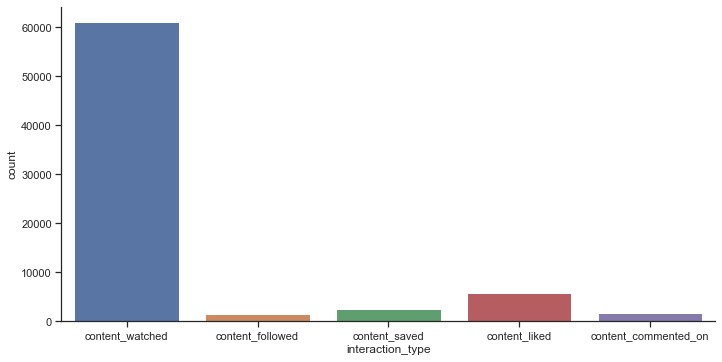

In [128]:
# distribution of interaction type
# Around 85% of the movies are of rating 1 (content_watched)
sns.catplot(x="interaction_type", kind="count", height=5, aspect=2, data=consumer_interaction)

In [129]:
# Let's explore the consumer country and location
print(consumer_interaction.country.nunique())
print(consumer_interaction.country.unique())

23
[nan 'US' 'BR' 'JP' 'KR' 'IN' 'IE' 'SG' 'DE' 'CA' 'IS' 'AU' 'ZZ' 'ES' 'CN'
 'GB' 'MY' 'AR' 'NL' 'CL' 'IT' 'CO' 'PT' 'CH']


BR    51396
US     4657
KR      239
CA      226
JP      144
AU      138
GB       22
DE       19
IE       14
IS       13
SG       11
ZZ       11
AR        7
PT        6
ES        3
IN        3
MY        2
IT        2
NL        1
CL        1
CO        1
CN        1
CH        1
Name: country, dtype: int64


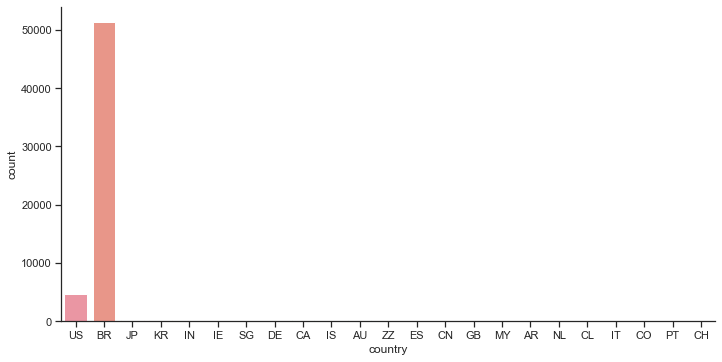

In [130]:
print(consumer_interaction.country.value_counts())
sns.catplot(x="country", kind="count", height=5, aspect=2, data=consumer_interaction)

In [131]:
consumer_interaction.consumer_location.unique()

array([nan, 'NY', 'MG', 'SP', 'RJ', 'GA', 'CA', '?', 'NJ', 'TX', '49',
       'MH', 'D', 'PA', 'VA', 'BE', 'AZ', 'IL', 'MI', 'FL', 'ES', 'BW',
       'MA', 'PR', 'BC', 'NSW', 'DF', 'C', 'HE', 'ON', 'MS', '13', '11',
       'DC', 'NE', 'NC', '33', 'CO', 'LA', 'ENG', 'GO', '14', 'IN', 'CT',
       '45', '27', 'WA', 'PE', 'MO', 'MN', 'RS', 'NH', '41', 'SC', 'BA',
       'WI', 'RM', 'OK', 'OH', 'CE', 'RI', 'AB', 'R', 'BOL', 'NV', 'OR',
       'KS', 'ZH', 'MT', 'QLD', 'PI', 'CL'], dtype=object)

In [132]:
consumer_interaction.consumer_location.value_counts()

SP     40164
MG     10229
NY      1257
TX       923
GA       910
RJ       775
NJ       698
?        327
CA       238
ON       202
NSW      135
IL       113
13       107
PR        88
MI        84
PA        76
FL        49
MA        39
49        39
ES        32
VA        30
CO        29
GO        23
ENG       22
AZ        20
BC        18
MS        17
KS        17
45        17
11        16
DF        16
OH        16
BA        14
BE        12
D         12
WA        11
DC        11
PE        10
CT        10
WI         9
C          8
SC         8
41         7
AB         6
BW         5
MO         5
LA         5
RS         4
27         4
RI         3
NE         3
OK         3
QLD        3
NV         3
MH         3
14         2
NC         2
HE         2
PI         2
IN         2
RM         2
R          1
CE         1
33         1
ZH         1
CL         1
OR         1
MT         1
MN         1
BOL        1
NH         1
Name: consumer_location, dtype: int64

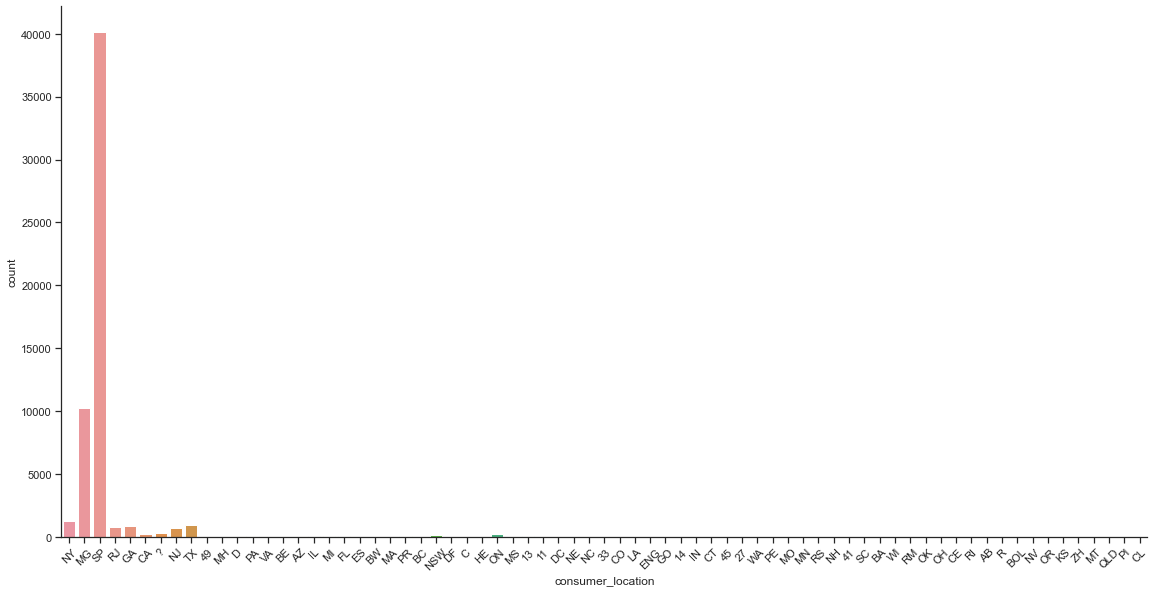

In [133]:
# let's plot the conumer location column
g = sns.catplot(x="consumer_location", kind="count", height=8, aspect=2, data=consumer_interaction)
g.set_xticklabels(rotation=45)



In [134]:
consumer_interaction

event_timestamp              item_id  interaction_type          consumer_id  ratings consumer_location country
0           1465413032 -3499919498720038879   content_watched -8845298781299428018      1.0               NaN     NaN
1           1465412560  8890720798209849691   content_watched -1032019229384696495      1.0                NY      US
2           1465416190   310515487419366995   content_watched -1130272294246983140      1.0               NaN     NaN
3           1465413895   310515487419366995  content_followed   344280948527967603      5.0               NaN     NaN
4           1465412290 -7820640624231356730   content_watched  -445337111692715325      1.0               NaN     NaN
...                ...                  ...               ...                  ...      ...               ...     ...
72307       1485190425 -6590819806697898649     content_liked -9016528795238256703      2.0                MG      BR
72308       1485190425 -5813211845057621660   content_watched   102305705598210278      1.0                SP      BR
72309       1485190072 -1999468346928419252   content_watched -9196668942822132778      1.0                SP      BR
72310       1485190434 -6590819806697898649   content_watched -9016528795238256703      1.0                MG      BR
72311       1485187988  5669290109546991426   content_watched  5713241217519616260      1.0                MG      BR

[72312 rows x 7 columns]

In [135]:
# Let's check for the duplicate entries.
consumer_interaction[consumer_interaction.duplicated(['item_id', 'consumer_id'])]

event_timestamp              item_id interaction_type          consumer_id  ratings consumer_location country
8           1465413762   310515487419366995  content_watched   344280948527967603      1.0               NaN     NaN
12          1465415228  3460026829794173084  content_watched  1908339160857512799      1.0                SP      BR
17          1465412288 -7820640624231356730  content_watched  -445337111692715325      1.0                MG      BR
20          1465416196   310515487419366995  content_watched -1130272294246983140      1.0                SP      BR
22          1465415060 -1492913151930215984  content_watched  4254153380739593270      1.0               NaN     NaN
...                ...                  ...              ...                  ...      ...               ...     ...
72305       1485187998   569574447134368517  content_watched -5230721907253934520      1.0                SP      BR
72306       1485190133  5484061377044071389  content_watched  3609194402293569455      1.0                SP      BR
72307       1485190425 -6590819806697898649    content_liked -9016528795238256703      2.0                MG      BR
72308       1485190425 -5813211845057621660  content_watched   102305705598210278      1.0                SP      BR
72310       1485190434 -6590819806697898649  content_watched -9016528795238256703      1.0                MG      BR

[31602 rows x 7 columns]

In [136]:
# let's handle the duplicate entries. 
# Sort using the eventtimestamp column, take the entry with latest timestamp.
consumer_interaction.sort_values(by=['event_timestamp'])

event_timestamp              item_id      interaction_type          consumer_id  ratings consumer_location country
25389       1457963676  8078873160882064481       content_watched  3891637997717104548      1.0                SP      BR
25390       1457964607  8078873160882064481       content_watched   692689608292948411      1.0                SP      BR
8301        1457966363  8078873160882064481       content_watched -6411371239765052331      1.0                TX      US
4560        1458147079  1179326165172129711       content_watched -5094446514734487376      1.0                SP      BR
11881       1458148861  1179326165172129711       content_watched -5299969637554720500      1.0                SP      BR
...                ...                  ...                   ...                  ...      ...               ...     ...
69511       1488300723  6607431762270322325       content_watched -1393866732742189886      1.0                MG      BR
71148       1488307874  4109618890343020064       content_watched  3891637997717104548      1.0                SP      BR
71150       1488308005  4109618890343020064  content_commented_on  3891637997717104548      4.0                SP      BR
71149       1488308005  4109618890343020064      content_followed  3891637997717104548      5.0                SP      BR
70536       1488309711  4109618890343020064       content_watched -3954277405987282296      1.0                SP      BR

[72312 rows x 7 columns]

In [137]:
# Let's keep only the last entry
print(consumer_interaction[consumer_interaction.duplicated(['item_id', 'consumer_id'], keep='last')])
consumer_interaction.drop_duplicates(subset=['item_id', 'consumer_id'], keep='last', inplace=True)

       event_timestamp              item_id  interaction_type          consumer_id  ratings consumer_location country
0           1465413032 -3499919498720038879   content_watched -8845298781299428018      1.0               NaN     NaN
1           1465412560  8890720798209849691   content_watched -1032019229384696495      1.0                NY      US
2           1465416190   310515487419366995   content_watched -1130272294246983140      1.0               NaN     NaN
3           1465413895   310515487419366995  content_followed   344280948527967603      5.0               NaN     NaN
4           1465412290 -7820640624231356730   content_watched  -445337111692715325      1.0               NaN     NaN
...                ...                  ...               ...                  ...      ...               ...     ...
72277       1485784333 -1415040208471067980   content_watched  4313045637915476309      1.0                SP      BR
72281       1485781090   991271693336573226   content_wa

<ipython-input-137-6df1a7f5989b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumer_interaction.drop_duplicates(subset=['item_id', 'consumer_id'], keep='last', inplace=True)


In [138]:
consumer_interaction

event_timestamp              item_id interaction_type          consumer_id  ratings consumer_location country
12          1465415228  3460026829794173084  content_watched  1908339160857512799      1.0                SP      BR
17          1465412288 -7820640624231356730  content_watched  -445337111692715325      1.0                MG      BR
22          1465415060 -1492913151930215984  content_watched  4254153380739593270      1.0               NaN     NaN
26          1465415695  7763750328910542816  content_watched  1908339160857512799      1.0               NaN     NaN
30          1465413771  3064370296170038610  content_watched  3609194402293569455      1.0                SP      BR
...                ...                  ...              ...                  ...      ...               ...     ...
72306       1485190133  5484061377044071389  content_watched  3609194402293569455      1.0                SP      BR
72308       1485190425 -5813211845057621660  content_watched   102305705598210278      1.0                SP      BR
72309       1485190072 -1999468346928419252  content_watched -9196668942822132778      1.0                SP      BR
72310       1485190434 -6590819806697898649  content_watched -9016528795238256703      1.0                MG      BR
72311       1485187988  5669290109546991426  content_watched  5713241217519616260      1.0                MG      BR

[40710 rows x 7 columns]

In [139]:
# Removing unnecessary columns
consumer_interaction = consumer_interaction[['item_id', 'consumer_id', 'ratings']]

#### Explore plaform_content

In [140]:
# let's look at platform_content

platform_content.describe()


event_timestamp       item_id   producer_id  producer_session_id
count     3.122000e+03  3.122000e+03  3.122000e+03         3.122000e+03
mean      1.468804e+09  3.284110e+16  3.984819e+17         1.976675e+17
std       7.571512e+06  5.383734e+18  4.387115e+18         5.403753e+18
min       1.459193e+09 -9.222795e+18 -9.120686e+18        -9.212055e+18
25%       1.462369e+09 -4.660869e+18 -1.578288e+18        -4.651280e+18
50%       1.467136e+09  4.436584e+16 -7.092877e+17         4.154103e+17
75%       1.473873e+09  4.745617e+18  3.609194e+18         4.841644e+18
max       1.488308e+09  9.222265e+18  9.210531e+18         9.221043e+18

In [141]:
platform_content.head()

event_timestamp    interaction_type              item_id          producer_id  producer_session_id producer_device_info producer_location producer_country item_type                                           item_url                                              title                                   text_description language
0       1459192779  content_pulled_out -6451309518266745024  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://www.nytimes.com/2016/03/28/business/dea...  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en
1       1459193988     content_present -4110354420726924665  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://www.nytimes.com/2016/03/28/business/dea...  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en
2       1459194146     content_present -7292285110016212249  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://cointelegraph.com/news/bitcoin-future-w...  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en
3       1459194474     content_present -6151852268067518688  3891637997717104548 -1457532940883382585                  NaN               NaN              NaN      HTML  https://cloudplatform.googleblog.com/2016/03/G...                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en
4       1459194497     content_present  2448026894306402386  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  https://bitcoinmagazine.com/articles/ibm-wants...  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en

In [142]:
platform_content.language.value_counts()

en    2264
pt     850
la       4
ja       2
es       2
Name: language, dtype: int64

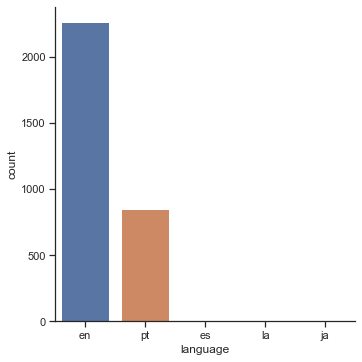

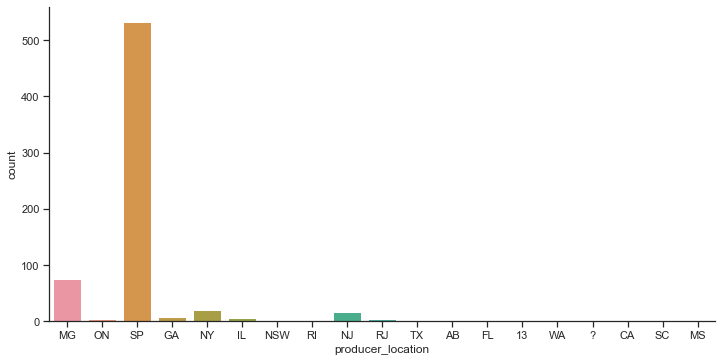

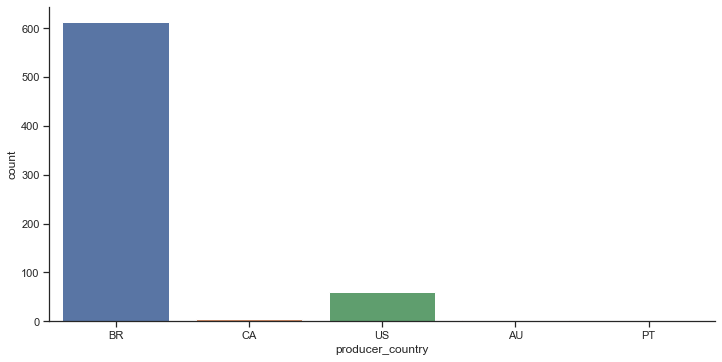

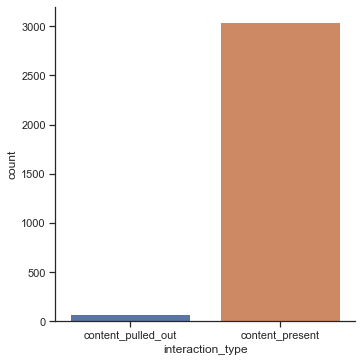

In [143]:
sns.catplot(x="language", kind="count", data=platform_content)
sns.catplot(x="producer_location", kind="count", height=5, aspect=2, data=platform_content)
sns.catplot(x="producer_country", kind="count", height=5, aspect=2, data=platform_content)
sns.catplot(x="interaction_type", kind="count", data=platform_content)

In [144]:
platform_content.item_type.nunique()

3

In [145]:
platform_content.item_type.unique()

array(['HTML', 'RICH', 'VIDEO'], dtype=object)

In [146]:
platform_content.item_url.nunique()

3029

In [147]:
# taking relevant columns
platform_content = platform_content[['interaction_type', 'item_id', 'producer_id', 'title',
                                     'producer_location', 'producer_country', 'text_description', 'language']]
platform_content

interaction_type              item_id          producer_id                                              title producer_location producer_country                                   text_description language
0     content_pulled_out -6451309518266745024  4340306774493623681  Ethereum, a Virtual Currency, Enables Transact...               NaN              NaN  All of this work is still very early. The firs...       en
1        content_present -4110354420726924665  4340306774493623681  Ethereum, a Virtual Currency, Enables Transact...               NaN              NaN  All of this work is still very early. The firs...       en
2        content_present -7292285110016212249  4340306774493623681  Bitcoin Future: When GBPcoin of Branson Wins O...               NaN              NaN  The alarm clock wakes me at 8:00 with stream o...       en
3        content_present -6151852268067518688  3891637997717104548                       Google Data Center 360° Tour               NaN              NaN  We're excited to share the Google Data Center ...       en
4        content_present  2448026894306402386  4340306774493623681  IBM Wants to "Evolve the Internet" With Blockc...               NaN              NaN  The Aite Group projects the blockchain market ...       en
...                  ...                  ...                  ...                                                ...               ...              ...                                                ...      ...
3117     content_present  9213260650272029784  3609194402293569455  Conheça a Liga IoT, plataforma de inovação abe...                SP               BR  A Liga Ventures, aceleradora de startups espec...       pt
3118     content_present -3295913657316686039  6960073744377754728  Amazon takes on Skype and GoToMeeting with its...                GA               US  Amazon has launched Chime, a video conferencin...       en
3119     content_present  3618271604906293310  1908339160857512799                        Code.org 2016 Annual Report                SP               BR  February 9, 2017 - We begin each year with a l...       en
3120     content_present  6607431762270322325 -1393866732742189886  JPMorgan Software Does in Seconds What Took La...                MG               BR  At JPMorgan Chase & Co., a learning machine is...       en
3121     content_present  4109618890343020064  3891637997717104548               The 2017 Acquia Partners of the Year                SP               BR  The Acquia Partner Awards Program is comprised...       en

[3122 rows x 8 columns]

In [148]:
# Total number of unique items in consumer_interactions
print(consumer_interaction.item_id.nunique())

print(platform_content.item_id.nunique())

print(platform_content.item_id.nunique() - consumer_interaction.item_id.nunique())

2987
3057
70


In [149]:
# list the items missing from consumer_interaction
set(platform_content.item_id.unique()) - set(consumer_interaction.item_id.unique())

{-8858741052589364245,
 -8531951303518498324,
 -8473322535064919980,
 -8294676699502353515,
 -8120372343967636100,
 -8112397019636931887,
 -8044741783031984918,
 -7904267039294833672,
 -7863574628164051955,
 -7814257818245609902,
 -7414654466964102039,
 -6275771337261603227,
 -5997023418322622504,
 -5968239566051821631,
 -5802731238371220572,
 -5623496706605874646,
 -4880614998012292765,
 -4291244850221551577,
 -3319960804317299025,
 -2880002165720705376,
 -2649418407515952078,
 -2309481887656981309,
 -2273517184910006534,
 -2148899391355011268,
 -1549326815285717811,
 -847494979958007433,
 -776023644693624658,
 -609005539129550395,
 -504935756748713175,
 -456161980484814803,
 -253149055249888078,
 -74919696966767903,
 5268351851132250,
 245828856632598563,
 476793294516827044,
 614512039577184122,
 756136904399885845,
 984451487666392184,
 1058260959930395162,
 1181375551449952059,
 1190376095547142533,
 1347061627677516149,
 1400543852157442197,
 1790561775815571583,
 202286947328041

In [150]:
set(consumer_interaction.item_id.unique()) - set(platform_content.item_id.unique())

set()

In [151]:
# Remove unnecessary columns
consumer_interaction = consumer_interaction[['item_id', 'consumer_id', 'ratings']]

In [152]:
platform_content.interaction_type.value_counts()

content_present       3047
content_pulled_out      75
Name: interaction_type, dtype: int64

In [153]:
platform_content['availability'] = platform_content['interaction_type'].map({'content_present': 1, 'content_pulled_out': 0})
platform_content = platform_content[['item_id', 'title', 'text_description', 'language', 'availability']]

<ipython-input-153-90b234cff56d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platform_content['availability'] = platform_content['interaction_type'].map({'content_present': 1, 'content_pulled_out': 0})


In [154]:
platform_content

item_id                                              title                                   text_description language  availability
0    -6451309518266745024  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             0
1    -4110354420726924665  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             1
2    -7292285110016212249  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en             1
3    -6151852268067518688                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en             1
4     2448026894306402386  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en             1
...                   ...                                                ...                                                ...      ...           ...
3117  9213260650272029784  Conheça a Liga IoT, plataforma de inovação abe...  A Liga Ventures, aceleradora de startups espec...       pt             1
3118 -3295913657316686039  Amazon takes on Skype and GoToMeeting with its...  Amazon has launched Chime, a video conferencin...       en             1
3119  3618271604906293310                        Code.org 2016 Annual Report  February 9, 2017 - We begin each year with a l...       en             1
3120  6607431762270322325  JPMorgan Software Does in Seconds What Took La...  At JPMorgan Chase & Co., a learning machine is...       en             1
3121  4109618890343020064               The 2017 Acquia Partners of the Year  The Acquia Partner Awards Program is comprised...       en             1

[3122 rows x 5 columns]

## User based collaborative filtering

In [155]:
print(consumer_interaction.item_id.nunique())
print(consumer_interaction.consumer_id.nunique())

2987
1895


In [156]:
consumer_interaction_train, consumer_interaction_test = train_test_split(consumer_interaction, test_size=0.30, random_state=31)

In [157]:
print(consumer_interaction_train.shape)
print(consumer_interaction_test.shape)

(28497, 3)
(12213, 3)


In [158]:
# Let's create the user X item matrix
data_matrix_train = consumer_interaction_train.pivot(
    index='consumer_id',
    columns='item_id',
    values='ratings'
).fillna(0)


# data_matrix_test = consumer_interaction_test.pivot(
#     index='consumer_id',
#     columns='item_id',
#     values='ratings'
# ).fillna(0)

# data_matrix_complete =  consumer_interaction.pivot(
#     index='consumer_id',
#     columns='item_id',
#     values='ratings'
# ).fillna(0)
data_matrix_train.shape

(1794, 2883)

In [159]:
data_matrix_train

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9153494109165200346  -9152398073968262186  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9207251133131336884            

In [160]:
# Let's calculate the pairwise distance

consumer_similarity = 1 - pairwise_distances(data_matrix_train, metric='cosine')
# consumer_similarity[np.isnan(consumer_similarity)] = 0
consumer_similarity

array([[1.        , 0.        , 0.        , ..., 0.02819419, 0.05423261,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.28284271,
        0.        ],
       ...,
       [0.02819419, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05423261, 0.        , 0.28284271, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [161]:
# Dot product of consumer_similarity matrix and data_matrix_test to get the predictions

item_prediction = np.dot(consumer_similarity, data_matrix_train)

In [162]:
item_prediction

array([[0.06859943, 0.18636993, 0.26479326, ..., 0.2493742 , 0.44303747,
        0.10438396],
       [0.        , 0.73625521, 0.04391861, ..., 0.        , 0.19611614,
        0.        ],
       [0.        , 2.2725771 , 0.        , ..., 0.05      , 0.24806947,
        0.        ],
       ...,
       [0.02559689, 0.        , 0.40190544, ..., 0.08481249, 0.33772372,
        0.01389425],
       [0.        , 0.33483024, 0.1635471 , ..., 0.1294327 , 0.45485437,
        0.        ],
       [0.0147442 , 0.04755193, 0.46777489, ..., 0.09277062, 0.38792102,
        0.02791724]])

In [163]:
item_prediction.shape

(1794, 2883)

In [164]:
len(list(data_matrix_train.columns))

2883

In [165]:
# Set the columns with item ids
# item_prediction_df = pd.DataFrame(item_prediction, columns=list(data_matrix_train.columns))
# item_prediction_df.insert(0, 'consumer_id', data_matrix_train.reset_index().consumer_id)
# item_prediction_df.set_index(["consumer_id"],append = True, drop = True, inplace=True)

In [166]:
item_prediction_df = pd.DataFrame(item_prediction, columns=list(data_matrix_train.columns), index=data_matrix_train.index)

In [167]:
item_prediction_df

-9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9153494109165200346  -9152398073968262186  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404              0.068599              0.186370              0.264793              1.455150              0.084063              0.604257              0.770043              0.083340              0.092033              0.086627              0.394922              0.054403              0.057551              0.036564              0.100502              0.103666              0.604165              0.543871              0.104451              0.049252              0.030000              0.214230              0.044952              0.176965                   0.0              0.153011              0.205128              0.252537              0.451622              0.341943              0.124237              0.047503              0.123768              0.468473              0.265966              0.208082              0.246520              0.603925              0.419702              0.052715              0.111095              0.054384              0.207226              0.025016   
-9212075797126931087              0.000000              0.736255              0.043919              0.190631              0.000000              0.167255              0.056334              0.000000              0.026426              0.000000              0.196116              0.000000              0.000000              0.000000              0.020655              0.000000              0.017493              0.287474              0.017493              0.000000              0.017493              0.091287              0.000000              0.000000                   0.0              0.026135              0.038148              0.046790              0.082469              0.000000              0.017493              0.017493              0.000000              0.168784              0.000000              0.102430              0.017493              0.000000              0.052162              0.017493              0.104446              0.026426              0.140028              0.000000   
-9207251133131336884              0.000000            

In [168]:
item_prediction_df.loc[-9223121837663643404]

-9222795471790223670    0.068599
-9216926795620865886    0.186370
-9194572880052200111    0.264793
-9192549002213406534    1.455150
-9190737901804729417    0.084063
                          ...   
 9213260650272029784    0.155193
 9215261273565326920    0.418723
 9217155070834564627    0.249374
 9220445660318725468    0.443037
 9222265156747237864    0.104384
Name: -9223121837663643404, Length: 2883, dtype: float64

In [169]:
# Create a dummy train pivot table for recommending unseen items.
# Dummy train will be used later for prediction of the items which has not been rated by the user. 
# To ignore the items rated by the user, we will mark it as 0 during prediction. 
# The items not rated by user is marked as 1 for prediction in dummy train dataset.

dummy_train = data_matrix_train.copy()

In [170]:
for c in dummy_train.columns:
    dummy_train[c] = dummy_train[c].apply(lambda x: 1.0 if x == 0.0 else 0.0)

In [171]:
dummy_train

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9153494109165200346  -9152398073968262186  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0   
-9212075797126931087                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0   
-9207251133131336884            

In [172]:
item_pred_unseen = np.multiply(item_prediction,dummy_train)

In [173]:
item_pred_unseen

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9153494109165200346  -9152398073968262186  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404              0.068599              0.186370              0.264793              1.455150              0.084063              0.604257              0.770043              0.083340              0.092033              0.086627              0.394922              0.054403              0.057551              0.036564              0.100502              0.103666              0.604165              0.543871              0.104451              0.049252              0.030000              0.214230              0.044952              0.176965                   0.0              0.153011              0.205128              0.252537              0.451622              0.341943              0.124237              0.047503              0.123768              0.468473              0.265966              0.208082              0.246520              0.603925              0.419702              0.052715              0.111095              0.054384              0.207226              0.025016   
-9212075797126931087              0.000000              0.736255              0.043919              0.190631              0.000000              0.167255              0.056334              0.000000              0.026426              0.000000              0.196116              0.000000              0.000000              0.000000              0.020655              0.000000              0.017493              0.287474              0.017493              0.000000              0.017493              0.091287              0.000000              0.000000                   0.0              0.026135              0.038148              0.046790              0.082469              0.000000              0.017493              0.017493              0.000000              0.168784              0.000000              0.102430              0.017493              0.000000              0.052162              0.017493              0.104446              0.026426              0.140028              0.000000   
-9207251133131336884            

In [174]:
platform_content

item_id                                              title                                   text_description language  availability
0    -6451309518266745024  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             0
1    -4110354420726924665  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             1
2    -7292285110016212249  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en             1
3    -6151852268067518688                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en             1
4     2448026894306402386  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en             1
...                   ...                                                ...                                                ...      ...           ...
3117  9213260650272029784  Conheça a Liga IoT, plataforma de inovação abe...  A Liga Ventures, aceleradora de startups espec...       pt             1
3118 -3295913657316686039  Amazon takes on Skype and GoToMeeting with its...  Amazon has launched Chime, a video conferencin...       en             1
3119  3618271604906293310                        Code.org 2016 Annual Report  February 9, 2017 - We begin each year with a l...       en             1
3120  6607431762270322325  JPMorgan Software Does in Seconds What Took La...  At JPMorgan Chase & Co., a learning machine is...       en             1
3121  4109618890343020064               The 2017 Acquia Partners of the Year  The Acquia Partner Awards Program is comprised...       en             1

[3122 rows x 5 columns]

In [175]:
# Recommended items for the user -9212075797126931087

d = item_pred_unseen.loc[-9212075797126931087]

### Top 10 recommendations for -9212075797126931087

In [176]:
merged = pd.merge(d,platform_content,left_on='item_id',right_on='item_id', how = 'left')

In [177]:
merged

item_id  -9212075797126931087                                              title                                   text_description language  availability
0    -9222795471790223670              0.000000  Uber lança serviço de helicóptero em SP com pr...  O Uber anunciou nesta segunda-feira, 13/06, o ...       pt             1
1    -9216926795620865886              0.736255  Request lesson : How and when to use はず(=hazu)...  = Kotoshi no aki made niwa kare ga dekiru hazu...       la             1
2    -9194572880052200111              0.043919  STEMTera, uma protoboard com Arduino Uno embutido  Protoboard de 400 pinos + Arduino Uno em um só...       pt             1
3    -9192549002213406534              0.190631  Chrome OS now has Material Design for the desktop  Chromebook users are in for a surprise: Chrome...       en             1
4    -9190737901804729417              0.000000                        The Real Product Market Fit  Michael Seibel, Y Combinator Partner, on knowi...       en             1
...                   ...                   ...                                                ...                                                ...      ...           ...
2929  9213260650272029784              0.058048  Conheça a Liga IoT, plataforma de inovação abe...  A Liga Ventures, aceleradora de startups espec...       pt             1
2930  9215261273565326920              0.048113  Meet Mycroft, the open source AI who wants to ...  Image: Mycroft It might bear a passing resembl...       en             1
2931  9217155070834564627              0.000000  Ray Kurzweil Predicts Three Technologies Will ...  55 0 Over the last several decades, the digita...       en             1
2932  9220445660318725468              0.196116                                          Angular 2  Welcome to the Angular 2 Style Guide Purpose I...       en             1
2933  9222265156747237864              0.000000  Deep-learning neural network creates its own i...  Way back in 2005, when Will Wright unveiled Sp...       en             1

[2934 rows x 6 columns]

In [178]:
# Filtering only the available items
merged = merged[merged.availability == 1]

In [179]:
merged.sort_values(by=[-9212075797126931087], ascending=False)[0:10]

item_id  -9212075797126931087                                              title                                   text_description language  availability
2661  7521700660190108859              1.161268  Como são escrita as risadas em japonês? - Suki...  Todos conhecem as universais formas de risadas...       pt             1
2655  7507067965574797372              1.116234  Um bilhão de arquivos mostram quem vence a dis...  Esta é uma das maiores batalhas já travadas en...       pt             1
605  -5527182266336855540              1.003047                    40 Basic Japanese conversations  Japanese conversation using Ninja LINE sticker...       ja             1
856  -3790313320969344469              0.988589                                  The Great Library  hen learning Japanese, reading often makes up ...       en             1
387  -6843047699859121724              0.922956  Ganhe 6 meses de acesso ao Pluralsight, maior ...  Ganhe 6 meses de acesso ao Pluralsight, maior ...       pt             1
766  -4434534460030275781              0.870512  The Algorithm March, Japan's Strangely Enterta...  Arugorizumu Koushin! アルゴリズムこうしん (Algorithm Mar...       ja             1
1843  2581138407738454418              0.807423       10 Modern Software Over-Engineering Mistakes  10 Modern Software Over-Engineering Mistakes F...       en             1
1    -9216926795620865886              0.736255  Request lesson : How and when to use はず(=hazu)...  = Kotoshi no aki made niwa kare ga dekiru hazu...       la             1
557  -5784991738549272379              0.684726  NodeMCU (ESP8266) o módulo que desbanca o Ardu...  A partir de 2005 o Arduino se tornou a princip...       pt             1
398  -6783772548752091658              0.644319                   Livro: Retrospectivas Divertidas  Neste livro, nós fornecemos um conjunto de fer...       pt             1

### Evaluation

In [180]:
# Find out the common users of test and train dataset.
# This is to filter out the required user similarity values
common = consumer_interaction_test[consumer_interaction_test.consumer_id.isin(consumer_interaction_train.consumer_id)]
common.shape

(12088, 3)

In [181]:
common.consumer_id.nunique()

1344

In [182]:
common.item_id.nunique()

2505

In [183]:
common

item_id          consumer_id  ratings
59671  7506614456429888492 -6944500707172804068      1.0
59351 -8954346068661072425   434517017614495946      1.0
53682   886450434856305025   599868086167624974      1.0
9672   8589361101754366293  3622641762376806537      1.0
22501 -3027055440570405664  1908339160857512799      1.0
...                    ...                  ...      ...
60664  2106559900295325351 -6668715715951053690      1.0
22820 -2539915991213675511  5660542693104786364      1.0
13557 -3027055440570405664 -7267769888748948232      1.0
16733 -4740532350684079805 -8550167523008133722      NaN
67176   -14569272361926584  1766127404965083143      1.0

[12088 rows x 3 columns]

In [184]:
common_consumer_based_matrix = common.pivot(index='consumer_id', columns='item_id', values='ratings').fillna(0)

In [185]:
consumer_similarity_df = pd.DataFrame(consumer_similarity, index=data_matrix_train.index, columns=data_matrix_train.index)

In [186]:
consumer_similarity_df

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9150583489352258206  -9120685872592674274  -9109785559521267180  -9099478998637725255  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8984152171875293281  -8965597312806628567  -8965390025652957482  -8961797610770561652  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8859417914913317336  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8821868115755885910  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8765011947844411605  -8763398617720485024  -8743976205985209861  -8738496712327699923  -8719462623048086192  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404              1.000000                   0.0              0.000000                   0.0                   0.0                   0.0              0.118033              0.000000                   0.0              0.021958              0.090951                   0.0                   0.0              0.000000              0.121268                   0.0              0.050528              0.033706              0.058824              0.000000                   0.0              0.000000                   0.0                   0.0              0.000000              0.000000               0.00000              0.104010                   0.0                   0.0              0.048187              0.011308              0.027821              0.000000                   0.0                   0.0              0.042875              0.076696              0.000000                   0.0                0.0245                   0.0                   0.0              0.000000   
-9212075797126931087              0.000000                   1.0              0.000000                   0.0                   0.0                   0.0              0.000000              0.094491                   0.0              0.000000              0.000000                   0.0                   0.0              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000                   0.0                   0.0              0.000000              0.000000               0.00000              0.000000                   0.0                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0                   0.0              0.000000              0.000000              0.000000                   0.0                0.0000                   0.0                   0.0              0.000000   
-9207251133131336884            

In [187]:
# Get the user similarity of the common users
list_name = common.consumer_id.tolist()


consumer_similarity_df_1 = consumer_similarity_df[consumer_similarity_df.index.isin(list_name)]
consumer_similarity_df_2 = consumer_similarity_df_1.T[consumer_similarity_df_1.T.index.isin(list_name)]
consumer_similarity_df_3 = consumer_similarity_df_2.T

In [188]:
len(set(list_name))

1344

In [189]:
consumer_similarity_df_3

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8965597312806628567  -8965390025652957482  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  -8674958742744576254  -8672331451814079632  -8670749047273764903  -8652741825481604192  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404              1.000000                   0.0              0.000000                   0.0                   0.0                   0.0              0.118033              0.000000              0.021958              0.090951                   0.0              0.000000              0.121268                   0.0              0.050528              0.033706              0.058824              0.000000                   0.0                   0.0                   0.0              0.000000               0.00000              0.104010                   0.0              0.048187              0.011308              0.027821              0.000000                   0.0              0.042875              0.076696              0.000000                0.0245                   0.0              0.000000                   0.0              0.000000              0.030317              0.070014              0.022327              0.000000              0.000000              0.000000   
-9212075797126931087              0.000000                   1.0              0.000000                   0.0                   0.0                   0.0              0.000000              0.094491              0.000000              0.000000                   0.0              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0                   0.0                   0.0              0.000000               0.00000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000                0.0000                   0.0              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000   
-9207251133131336884            

In [190]:
predictions_eval = np.dot(consumer_similarity_df_3, common_consumer_based_matrix.fillna(0))

In [191]:
consumer_similarity_df_3

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8965597312806628567  -8965390025652957482  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  -8674958742744576254  -8672331451814079632  -8670749047273764903  -8652741825481604192  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404              1.000000                   0.0              0.000000                   0.0                   0.0                   0.0              0.118033              0.000000              0.021958              0.090951                   0.0              0.000000              0.121268                   0.0              0.050528              0.033706              0.058824              0.000000                   0.0                   0.0                   0.0              0.000000               0.00000              0.104010                   0.0              0.048187              0.011308              0.027821              0.000000                   0.0              0.042875              0.076696              0.000000                0.0245                   0.0              0.000000                   0.0              0.000000              0.030317              0.070014              0.022327              0.000000              0.000000              0.000000   
-9212075797126931087              0.000000                   1.0              0.000000                   0.0                   0.0                   0.0              0.000000              0.094491              0.000000              0.000000                   0.0              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0                   0.0                   0.0              0.000000               0.00000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000                0.0000                   0.0              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000   
-9207251133131336884            

In [192]:
pd.DataFrame(predictions_eval)

0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25    26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57        58    59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93        94        95        96        97        98        99    \
0     1.124027  0.000000  0.165113  0.697748  0.074451  0.391335  0.011696  0.293556  0.057551  0.070014  0.057551  0.000000  0.404576  0.000000  0.030000  0.148861  0.489634  0.056676  0.158927  0.118033  0.145521  0.020991  0.066554  0.178343  0.179279  0.345909   0.0  0.107941  0.725369  0.205009  0.336116  0.187249  0.358875  0.061604  0.084384  0.139753  0.036564  0.000000  0.341481  0.076602  0.076139  0.517961  0.322595  0.045085  0.010719  0.690417  0.575452  0.098608  0.056676  0.088995  0.083264  0.057551  0.846605  0.385734  1.222268  0.145004  0.000000  0.064820  0.120734   0.0  0.066421  0.000000  0.336280  0.173607  0.063266  0.163390  0.116605  0.195741  0.040423  0.056676  0.215567  0.068350  0.238018  0.031985  0.577310  0.428348  0.201606  0.193247  0.903580  0.258299  0.096688  0.113576  0.041292  0.169928  0.019672  0.279505  0.195907  0.620526  0.049617  0.168707  0.000000  0.101747  0.045085  0.164293  0.137266  0.054384  0.219286  0.000000  0.074451  0.265259   
1     0.000000  0.223607  0.000000  0.123196  0.000000  0.064282  0.000000  0.091586  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.017493  0.000000  0.025516  0.020655  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  0.043919  0.020655  0.056334  0.000000  0.000000  0.044721  0.000000  0.043919  0.000000  0.000000  0.000000  0.070054  0.000000  0.056334  0.017493  0.000000  0.056334  0.000000  0.000000  0.000000  0.026135  0.020655  0.000000  0.056334  0.000000  0.092834  0.088921  0.107246  0.048337  0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.043919  0.000000  0.020655  0.056334  0.020655  0.000000  0.020655  0.104446  0.000000  0.084515  0.000000  0.000000  0.017493  0.000000  0.000000  0.064282  0.048113  0.092834  0.093058  0.000000  0.020655  0.000000  0.000000  0.000000  0.475413  0.049507  0.000000  0.000000  0.000000  0.056334  0.070014  0.017493  0.026426  0.000000  0.000000  0.000000  0.017493   
2     0.152416  0.400000  0.423691  0.067806  0.055470  0.232908  0.000000  0.210819  0.000000  0.000000  0.000000  0.000000  0.050000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.054738  0.000000  0.000000  0.000000  0.000000   0.0  0.316228  0.055470  0.000000  0.473554  0.000000  0.080000  0.000000  0.000000  0.000000  0.000000  0.158114  0.093505  0.000000  0.000000  0.067806  0.537182  0.000000  0.000000  1.659850  0.139686  0.093505  0.000000  0.000000  0.080648  0.000000  0.487312  0.340578  0.599778  0.230940  0.000000  0.000000  0.000000   0.0  0.115470  0.000000  0.000000  0.000000  0.000000  0.108465  0.000000  0.000000  0.239046  0.000000  0.279077  0.000000  0.151186  0.000000  0.221880  0.000000  0.057735  0.038104  0.407610  0.250650  0.080000  0.080000  0.000000  0.119523  0.000000  0.000000  0.057735  4.069353  0.000000  0.400000  0.000000  0.130648  0.000000  0.845403  0.000000  0.000000  0.299964  0.000000  0.055470  0.074278   
3     0.43

In [193]:
# Create a dummy test pivot table for evaluation
# let's replace values greater than 0 with 1 and others with zero
# then multiply it with the predictions

dummy_test = common_consumer_based_matrix.copy()
for c in dummy_test.columns:
    dummy_test[c] = dummy_test[c].apply(lambda x: 1.0 if x != 0.0 else 0.0)

In [194]:
predictions_eval = np.multiply(predictions_eval, dummy_test)

In [195]:
predictions_eval

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9184137057748005562  -9176143510534135851  -9172673334835262304  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9102431381393428051  -9100490342054218852  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9081753261356157170  -9076501258717815738  -9073210245497295284  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9040419159428373932  -9039021554659316935  -9033211547111606164  -9028990334396397584  -9020955625521881630  -9019582414165805420  -9019233957195913605  -9002191823887486987  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9207251133131336884            

In [196]:
predictions_eval.reset_index()[-9222795471790223670].value_counts()

0.000000    1341
5.435664       1
3.176830       1
4.791553       1
Name: -9222795471790223670, dtype: int64

### RMSE

In [197]:
X  = predictions_eval.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
y

MinMaxScaler(feature_range=(1, 5))


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [198]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

11803

In [199]:
rmse = (sum(sum((common_consumer_based_matrix - predictions_eval )**2))/total_non_nan)**0.5
print(rmse)

0.7678644959448444


## Item based collaborative filtering

In [200]:
data_matrix_train_item_item = data_matrix_train.T

In [201]:
data_matrix_train_item_item

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9150583489352258206  -9120685872592674274  -9109785559521267180  -9099478998637725255  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8984152171875293281  -8965597312806628567  -8965390025652957482  -8961797610770561652  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8859417914913317336  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8821868115755885910  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8765011947844411605  -8763398617720485024  -8743976205985209861  -8738496712327699923  -8719462623048086192  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   1.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [202]:
item_correlation = 1 - pairwise_distances(data_matrix_train_item_item, metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.11785113 0.        ]
 [0.         0.         0.         ... 0.11785113 1.         0.16666667]
 [0.         0.         0.         ... 0.         0.16666667 1.        ]]


In [203]:
item_correlation_df = pd.DataFrame(item_correlation, index=data_matrix_train_item_item.index, columns=data_matrix_train_item_item.index)

In [204]:
item_correlation_df

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9153494109165200346  -9152398073968262186  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670              1.000000                   0.0              0.000000              0.000000              0.258199              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0                   0.0                   0.0                   0.0              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000                   0.0                   0.0                   0.0              0.000000              0.000000                   0.0              0.124035              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000              0.282843              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0   
-9216926795620865886              0.000000                   1.0              0.000000              0.000000              0.000000              0.085749              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0                   0.0                   0.0                   0.0              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000                   0.0                   0.0                   0.0              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0   
-9194572880052200111            

### Items similar to -9190737901804729417

In [205]:
d = item_correlation_df.loc[-9190737901804729417]

In [206]:
d

item_id
-9222795471790223670    0.258199
-9216926795620865886    0.000000
-9194572880052200111    0.000000
-9192549002213406534    0.000000
-9190737901804729417    1.000000
                          ...   
 9213260650272029784    0.000000
 9215261273565326920    0.000000
 9217155070834564627    0.000000
 9220445660318725468    0.000000
 9222265156747237864    0.000000
Name: -9190737901804729417, Length: 2883, dtype: float64

In [207]:
item_merged = pd.merge(d,platform_content,left_on='item_id',right_on='item_id', how = 'left')

In [208]:
# Filtering only the available items
item_merged = item_merged[item_merged.availability == 1]

In [209]:
item_merged.sort_values(by=[-9190737901804729417], ascending=False)[0:11]

item_id  -9190737901804729417                                              title                                   text_description language  availability
4    -9190737901804729417              1.000000                        The Real Product Market Fit  Michael Seibel, Y Combinator Partner, on knowi...       en             1
2133  4338940510328721138              0.577350  Choose the Google Docs, Sheets, and Slides fil...  An internet connection isn't always easy to co...       en             1
1719  1729892529360390310              0.577350              5 motivos para não escrever 5 motivos  5 motivos para não escrever 5 motivos Estou am...       pt             1
128  -8529522981244750831              0.408248  How Technology Hijacks People's Minds - from a...  How Technology Hijacks People's Minds - from a...       en             1
291  -7509877147979461087              0.408248         Como ser menos ocupado em um mundo ocupado  Não estou certo quanto a resposta, mas duvido ...       pt             1
2525  6793894801847439981              0.408248                             Why Thieves Steal Soap  This article was written by Alex Mayyasi , a P...       en             1
444  -6537529846890876234              0.408248  Just shut up and let your devs concentrate, ad...  If you want to attract and keep developers, do...       en             1
1859  2642993575444549134              0.408248                       Smartwatch sales are tanking  Maybe not everyone is convinced they need a sm...       en             1
2608  7247406924790318523              0.408248                    Escolha o mais difícil. Sempre.  Escolha o mais difícil. Sempre. Porque seguir ...       pt             1
578  -5678159351655490918              0.408248  Roupas com Wifi e GPS? Desenvolvedor une tecno...  Nos dias 14 e 15 de maio acontece em São Paulo...       pt             1
1899  2879555397105020076              0.408248  These guys created an app that stops college s...  Pocket Points In 2014, Mitch Gardner and Rob R...       en             1

### Evaluation - Item based

In [276]:
# Find out the common users of test and train dataset.
# This is to filter out the required user similarity values
common_items = consumer_interaction_test[consumer_interaction_test.item_id.isin(consumer_interaction_train.item_id)]
common_items.shape

(12073, 3)

In [277]:
common_item_based_matrix = common_items.pivot(index='consumer_id', columns='item_id', values='ratings').fillna(0).T

In [285]:
common_item_based_matrix

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8965597312806628567  -8965390025652957482  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  -8674958742744576254  -8672331451814079632  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [287]:
common_item_based_matrix.loc[-9222795471790223670].value_counts()

0.0    1441
4.0       1
5.0       1
2.0       1
Name: -9222795471790223670, dtype: int64

In [279]:
common_items.item_id.nunique()

2403

In [280]:
item_correlation_df

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9153494109165200346  -9152398073968262186  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670              1.000000                   0.0              0.000000              0.000000              0.258199              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0                   0.0                   0.0                   0.0              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000                   0.0                   0.0                   0.0              0.000000              0.000000                   0.0              0.124035              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000              0.282843              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0   
-9216926795620865886              0.000000                   1.0              0.000000              0.000000              0.000000              0.085749              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0                   0.0                   0.0                   0.0              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000                   0.0                   0.0                   0.0              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0   
-9194572880052200111            

In [263]:
# Get the user similarity of the common users
list_item = common_items.item_id.tolist()


item_similarity_df_1 = item_correlation_df[item_correlation_df.index.isin(list_item)]
item_similarity_df_2 = item_similarity_df_1.T[item_similarity_df_1.T.index.isin(list_item)]
item_similarity_df_3 = item_similarity_df_2.T

In [264]:
len(set(list_item))

2403

In [265]:
item_similarity_df_3

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9102431381393428051  -9100490342054218852  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9076501258717815738  -9073210245497295284  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033211547111606164  -9028990334396397584  -9020955625521881630  -9019582414165805420  -9019233957195913605  -9002191823887486987  -8996656559398843485  -8992803137960175254  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670              1.000000                   0.0              0.000000              0.000000              0.258199              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0                   0.0              0.000000              0.000000              0.000000                   0.0              0.000000                   0.0              0.000000              0.000000                   0.0              0.124035              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.282843              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.073521              0.000000                   0.0              0.000000              0.000000   
-9216926795620865886              0.000000                   1.0              0.000000              0.000000              0.000000              0.085749              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000                   0.0                   0.0              0.000000              0.000000              0.000000                   0.0              0.000000                   0.0              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000   
-9194572880052200111            

In [266]:
common_item_based_matrix

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8965597312806628567  -8965390025652957482  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  -8674958742744576254  -8672331451814079632  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [267]:
predictions_item_eval = np.dot(item_similarity_df_3, common_item_based_matrix.fillna(0))

In [268]:
pd.DataFrame(predictions_item_eval)

0         1         2         3         4         5         6         7         8         9         10    11        12        13        14        15    16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57    58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88    89        90        91        92        93        94        95        96        97        98        99    \
0     0.343457  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.046625  0.000000   0.0  0.000000  0.000000  0.000000  0.846141   0.0  0.566062  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.501204  0.339143  0.000000  0.338687  1.219284  0.000000  0.000000  0.000000  0.055470  0.000000  0.000000  0.000000  0.000000  0.741605  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.571216  0.000000  0.043644   0.0  0.000000  0.000000  0.000000  0.127775  0.079057  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.105409  0.422577  0.127775  0.000000  0.000000  0.046625  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.298142  0.000000   
1     0.116930  0.000000  0.899162  0.045268  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.606816   0.0  0.000000  0.041380  0.000000  0.000000  0.000000  0.000000  0.358569  0.208108  0.094491  0.046029  0.154224  0.079057  0.000000  0.000000  0.000000  0.069338  0.000000  0.039778  0.082761  0.045268  0.087988  0.000000  0.000000  0.089803  0.000000  0.106299  0.000000  0.094491  0.077152  0.000000  0.000000  0.000000  0.116649  0.296182  0.069338  0.000000  0.000000  0.000000  0.217428  0.046029  0.000000   0.0  0.000000  0.000000  0.000000  0.073066  0.052129  0.000000  0.000000  0.000000  0.096374  0.000000  0.000000  0.058124  0.232064  0.000000  0.000000  0.000000  0.046029  0.000000  0.000000  0.000000  0.000000  0.069338  0.000000  0.075810  0.261158  0.027037  0.027037  0.000000  0.050000  0.000000   0.0  0.000000  0.000000  0.069338  0.046029  0.046029  0.075810  0.000000  0.081111  0.000000  0.145147   
2     0.364042  0.049629  0.115278  0.037424  0.055728  0.071429  0.440864  0.000000  0.119523  0.730271  0.329256   0.0  0.000000  0.000000  0.170022  5.391446   0.0  4.052750  0.594917  0.360680  0.000000  0.061314  0.039406  0.245522  0.184007  1.513997  0.000000  2.736950  1.199809  0.510686  0.188982  0.025254  0.248199  0.195271  1.951472  1.082523  0.297389  0.313613  0.339864  0.115868  0.264967  0.157468  0.987052  0.186126  0.458575  0.415955  0.074848  0.114948  0.059761  0.910701  0.032651  0.052414  0.000000  0.000000  0.358741  2.623240  0.000000  0.058733   0.0  0.056413  0.037796  0.358718  0.289642  0.194895  0.730032  0.037796  0.329647  0.318782  0.117727  0.122499  0.280306  2.821134  0.000000  0.064820  0.364094  0.417392  0.000000  0.000000  0.042258  0.000000  0.135316  0.069007  1.072252  0.780375  0.040876  0.420817  0.000000  0.210820  0.035714   0.0  0.061314  0.000000  0.026207  0.000000  0.000000  0.223055  0.101015  1.950431  1.655708  0.876639   
3     0.479459  0.219034  0.127379  0.1958

In [269]:
# Create a dummy test pivot table for evaluation
# let's replace values greater than 0 with 1 and others with zero
# then multiply it with the predictions

dummy_test = common_item_based_matrix.copy()
for c in dummy_test.columns:
    dummy_test[c] = dummy_test[c].apply(lambda x: 1.0 if x != 0.0 else 0.0)

In [270]:
common_item_based_matrix

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8965597312806628567  -8965390025652957482  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  -8674958742744576254  -8672331451814079632  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [293]:
dummy_test

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8965597312806628567  -8965390025652957482  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  -8674958742744576254  -8672331451814079632  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [289]:
dummy_test.loc[-9222795471790223670].value_counts()

0.0    1441
1.0       3
Name: -9222795471790223670, dtype: int64

In [290]:
predictions_item_eval = np.multiply(predictions_item_eval, dummy_test)

In [291]:
predictions_item_eval

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8965597312806628567  -8965390025652957482  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  -8674958742744576254  -8672331451814079632  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0              0.000000                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0              0.000000                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [83]:
predictions_eval.reset_index()[-9222795471790223670].value_counts()

0.000000    1341
5.435664       1
3.176830       1
4.791553       1
Name: -9222795471790223670, dtype: int64

In [292]:
predictions_item_eval.reset_index()

consumer_id              item_id  -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8965597312806628567  -8965390025652957482  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  -8674958742744576254  \
0           -9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0              0.000000                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
1           -9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0              0.000000                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
2           -9194572880052200111                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0              0.000000                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
3           -9192549002213406534                   0.0                  

### RMSE

In [296]:
X  = predictions_item_eval.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
y

MinMaxScaler(feature_range=(1, 5))


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [297]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

11791

In [299]:
rmse = (sum(sum((common_item_based_matrix - predictions_item_eval )**2))/total_non_nan)**0.5
print(rmse)

5.306988962124137


## Content based filtering

In [387]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import MatrixSimilarity


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\z0039jss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\z0039jss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\z0039jss\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\z0039jss\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [433]:
platform_content.language.unique()

array(['en', 'pt', 'es', 'la', 'ja'], dtype=object)

In [434]:
# filter english items
platform_content_en = platform_content[platform_content.language == 'en']

In [435]:
platform_content_en

item_id                                              title                                   text_description language  availability
0    -6451309518266745024  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             0
1    -4110354420726924665  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             1
2    -7292285110016212249  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en             1
3    -6151852268067518688                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en             1
4     2448026894306402386  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en             1
...                   ...                                                ...                                                ...      ...           ...
3116  4675505028897335428   Swift Top 10 Articles For The Past Year (v.2017)  For the past year , we've ranked nearly 9,000 ...       en             1
3118 -3295913657316686039  Amazon takes on Skype and GoToMeeting with its...  Amazon has launched Chime, a video conferencin...       en             1
3119  3618271604906293310                        Code.org 2016 Annual Report  February 9, 2017 - We begin each year with a l...       en             1
3120  6607431762270322325  JPMorgan Software Does in Seconds What Took La...  At JPMorgan Chase & Co., a learning machine is...       en             1
3121  4109618890343020064               The 2017 Acquia Partners of the Year  The Acquia Partner Awards Program is comprised...       en             1

[2264 rows x 5 columns]

In [436]:
# let's create a df with required columns

keywords_array = platform_content_en['text_description'].to_numpy() 

In [438]:
keywords_array

array(['All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several projects that make it easier to use Ethereum on its computing cloud, Azu

In [447]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return wordnet.NOUN


In [460]:

def preprocess(keywords_array):

    words_list = []
    stop_words = stopwords.words("english")
    stop_words.extend(['$', "'", "''", "'s", ',', '-', '.',':', '``', '!', '@', '#', '(', ')', '%', '^', '&', '*', '_', ':', ';'])

    for keyword in keywords_array:
        keyword = keyword.lower()

        words = nltk.pos_tag(word_tokenize(keyword))
#         print(words)
        wordnet_lemmatizer = WordNetLemmatizer()
        
        words_updated = []
        for word in words:
            if word[0] not in stop_words:  
                words_updated.append(wordnet_lemmatizer.lemmatize(word[0], pos=nltk_tag_to_wordnet_tag(word[1])))

        words_list.append(words_updated)
#         print(words_list)        
    return words_list

In [461]:
words_list = preprocess(keywords_array)

In [462]:
len(words_list)

2264

In [464]:
# create a dictionary from words list
dictionary = Dictionary(words_list) 

#create corpus where the corpus is a bag of words for each document
corpus = [dictionary.doc2bow(doc) for doc in words_list] 

#create tfidf model of the corpus
tfidf = TfidfModel(corpus) 

# Create the similarity matrix. This is the most important part where we get the similarities between the movies.
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

In [467]:
def item_recommendation(item_title):
    # get the item row
    movie = platform_content_en.loc[platform_content_en.title==item_title] 
    
    #split the keywords
    keywords = preprocess(movie['text_description'])

    #set the list of words to query_doc
    query_doc = keywords[0] 
    
    print(query_doc)
    
    # get a bag of words from the query_doc
    query_doc_bow = dictionary.doc2bow(query_doc) 

    #convert the regular bag of words model to a tf-idf model
    query_doc_tfidf = tfidf[query_doc_bow] 

    # get similarity values between input movie and all other movies
    similarity_array = sims[query_doc_tfidf] 

    #Convert to a Series
    similarity_series = pd.Series(similarity_array.tolist(), index=platform_content_en.title.values) 

    #get the most similar movies 
    similarity_output = similarity_series.sort_values(ascending=False)
    return similarity_output

In [469]:
item_recommendation('Google Data Center 360° Tour')[:10]

["'re", 'excite', 'share', 'google', 'data', 'center', '360°', 'tour', 'youtube', '360°', 'video', 'give', 'unprecedented', 'immersive', 'look', 'inside', 'one', 'data', 'center', 'several', 'way', 'view', 'video', 'desktop', 'use', 'google', 'chrome', 'use', 'mouse', 'trackpad', 'change', 'view', 'video', 'play', 'youtube', 'app', 'mobile', 'move', 'device', 'around', 'look', 'angle', 'video', 'play', 'immersive', 'way', 'view', 'use', 'google', 'cardboard', 'currently', 'support', 'android', 'youtube', 'app', 'ios', 'support', 'come', 'soon', 'load', 'video', 'youtube', 'app', 'tap', 'cardboard', 'icon', 'video', 'start', 'play', 'insert', 'phone', 'cardboard', 'look', 'around', 'little', 'background', 'several', 'month', 'ago', 'u', 'google', 'cloud', 'developer', 'advocacy', 'team', 'rare', 'opportunity', 'tour', 'google', 'data', 'center', 'dalles', 'oregon', 'many', 'u', 'see', 'non-google', 'data', 'center', 'career', 'experience', 'beyond', 'anything', 'ever', 'imagine', 'blow'

Google Data Center 360° Tour                                                         1.000000
YouTube's New Messenger Means You'll Never Have to Leave YouTube                     0.306462
This year's Founders' Letter                                                         0.258862
Google shares data center security and design best practices                         0.246858
[Tools] How to Record your Desktop Screen with YouTube                               0.204186
Google Cloud Platform: The smart person's guide - TechRepublic                       0.171407
Top 5 GCP NEXT breakout sessions on YouTube (so far)                                 0.171137
Here's proof that Google is getting serious about battling Facebook in a key area    0.157192
Google I/O 2016 Preview: A Chrome/Android merger? Project Tango? VR?                 0.156644
VR possibilities at Google I/O 2016: Four things I'm hoping to see                   0.156563
dtype: float64

## ALS

In [193]:
from implicit.evaluation import train_test_split

In [194]:
alpha = 40
consumer_interaction.shape[0]

40710

In [195]:
consumer_interaction.consumer_id.nunique()

1895

In [196]:
consumer_interaction

item_id          consumer_id  ratings
12     3460026829794173084  1908339160857512799      1.0
17    -7820640624231356730  -445337111692715325      1.0
22    -1492913151930215984  4254153380739593270      1.0
26     7763750328910542816  1908339160857512799      1.0
30     3064370296170038610  3609194402293569455      1.0
...                    ...                  ...      ...
72306  5484061377044071389  3609194402293569455      1.0
72308 -5813211845057621660   102305705598210278      1.0
72309 -1999468346928419252 -9196668942822132778      1.0
72310 -6590819806697898649 -9016528795238256703      1.0
72311  5669290109546991426  5713241217519616260      1.0

[40710 rows x 3 columns]

In [197]:
# csr_matrix cannot be created using negative indices. 
# To handle that, let's map consumer ids and items ids to positive values

unique_items = list(consumer_interaction.item_id.unique())
unique_consumers = list(consumer_interaction.consumer_id.unique())

items_indices = list(range(0, len(unique_items)))
consumer_indices = list(range(0, len(unique_consumers)))


unique_items_idx_dict_df = pd.DataFrame({'item_id': unique_items, 
                                         'item_idx': items_indices })

unique_consumer_idx_dict_df = pd.DataFrame({'consumer_id': unique_consumers, 
                                         'consumer_idx': consumer_indices })

In [198]:
# Let's merge

consumer_interaction_with_idx = pd.merge(consumer_interaction, unique_items_idx_dict_df, on='item_id', how='left')
consumer_interaction_with_idx = pd.merge(consumer_interaction_with_idx, unique_consumer_idx_dict_df, on='consumer_id', how='left')

In [199]:
consumer_interaction_with_idx

item_id          consumer_id  ratings  item_idx  consumer_idx
0      3460026829794173084  1908339160857512799      1.0         0             0
1     -7820640624231356730  -445337111692715325      1.0         1             1
2     -1492913151930215984  4254153380739593270      1.0         2             2
3      7763750328910542816  1908339160857512799      1.0         3             0
4      3064370296170038610  3609194402293569455      1.0         4             3
...                    ...                  ...      ...       ...           ...
40705  5484061377044071389  3609194402293569455      1.0      2819             3
40706 -5813211845057621660   102305705598210278      1.0      2813          1296
40707 -1999468346928419252 -9196668942822132778      1.0      2817          1664
40708 -6590819806697898649 -9016528795238256703      1.0      2818            86
40709  5669290109546991426  5713241217519616260      1.0      2856          1715

[40710 rows x 5 columns]

In [200]:
alpha = 40
sparse_user_item = csr_matrix( ([alpha] * consumer_interaction_with_idx.shape[0], (consumer_interaction_with_idx['consumer_idx'], consumer_interaction_with_idx['item_idx'])))

In [201]:
print(consumer_interaction_with_idx['consumer_idx'].nunique())
print(consumer_interaction_with_idx['item_idx'].nunique())
sparse_user_item

1895
2987


<1895x2987 sparse matrix of type '<class 'numpy.intc'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [202]:
sparse_item_user = sparse_user_item.T.tocsr()

In [203]:
# Building ALS model
als_model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20, calculate_training_loss=False)

In [204]:
# train als model
als_model.fit(sparse_item_user)


In [247]:
als_model

In [205]:
consumer_interaction_with_idx

item_id          consumer_id  ratings  item_idx  consumer_idx
0      3460026829794173084  1908339160857512799      1.0         0             0
1     -7820640624231356730  -445337111692715325      1.0         1             1
2     -1492913151930215984  4254153380739593270      1.0         2             2
3      7763750328910542816  1908339160857512799      1.0         3             0
4      3064370296170038610  3609194402293569455      1.0         4             3
...                    ...                  ...      ...       ...           ...
40705  5484061377044071389  3609194402293569455      1.0      2819             3
40706 -5813211845057621660   102305705598210278      1.0      2813          1296
40707 -1999468346928419252 -9196668942822132778      1.0      2817          1664
40708 -6590819806697898649 -9016528795238256703      1.0      2818            86
40709  5669290109546991426  5713241217519616260      1.0      2856          1715

[40710 rows x 5 columns]

In [206]:
unique_consumer_idx_dict_df

consumer_id  consumer_idx
0     1908339160857512799             0
1     -445337111692715325             1
2     4254153380739593270             2
3     3609194402293569455             3
4    -8845298781299428018             4
...                   ...           ...
1890 -2963498984503943298          1890
1891 -5573063483172708129          1891
1892  8641138310821193516          1892
1893  8113637998311268223          1893
1894  6034801943312383646          1894

[1895 rows x 2 columns]

In [252]:
# user id -9207251133131336884, corresponding user idx
user_idx = unique_consumer_idx_dict_df[unique_consumer_idx_dict_df.consumer_id == -9207251133131336884]['consumer_idx'].item()

rec = als_model.recommend(user_idx, sparse_user_item)
output_df = pd.DataFrame(rec, columns=['item_idx', 'als_score'])
output_df = pd.merge(output_df, unique_items_idx_dict_df, on='item_idx', how='left')
output_df = output_df[['als_score', 'item_id']]
pd.merge(output_df, platform_content, on='item_id', how='left')

als_score              item_id                                              title                                   text_description language  availability
0   0.770152 -5527182266336855540                    40 Basic Japanese conversations  Japanese conversation using Ninja LINE sticker...       ja             1
1   0.686865  9136323715291453594  How to Improve 8 Major Problem Areas for Japan...  Have you hit a big ol' wall while learning Jap...       en             1
2   0.638307  5162508842577612756                               Japanese for dummies  Life is full of ki-do-ai-raku (kee-doh-ah-ee-r...       en             1
3   0.497494 -4888170580455425266          Speeding up ReSharper (and Visual Studio)  This document presents a list of performance o...       en             1
4   0.456785  8814787788150050622  Learn Japanese Online | Japanese Podcast| Japa...  First of all, the name itself (which is pronou...       en             1
5   0.445265 -3790313320969344469                                  The Great Library  hen learning Japanese, reading often makes up ...       en             1
6   0.445247 -8939172344092554931  Google DeepMind Is Now Analysing Magic And Hea...  With retro games and Go well-conquered , where...       en             1
7   0.372165  2581138407738454418       10 Modern Software Over-Engineering Mistakes  10 Modern Software Over-Engineering Mistakes F...       en             1
8   0.359921  4084131344684656470     The Children's Illustrated Guide to Kubernetes  Kubernetes, Book Introducing Phippy, an intrep...       en             1
9   0.353916  4609121753781446855  Lava-louças Brastemp Ative! 8 Serviços Blf08ab...  R$ 800 00 Entrega a combinar com o vendedor Ja...       pt             1

In [255]:
# find items similar to -282629989972409543. Let's get the corresponding index
item_idx = unique_items_idx_dict_df[unique_items_idx_dict_df.item_id == -282629989972409543]['item_idx'].item()
similar = als_model.similar_items(item_idx, 10)
similar_df = pd.DataFrame(similar, columns=['item_idx', 'als_score'])
similar_df = pd.merge(similar_df, unique_items_idx_dict_df, on='item_idx', how='left')
similar_df = similar_df[['als_score', 'item_id']]
pd.merge(similar_df, platform_content, on='item_id', how='left')

als_score              item_id                                              title                                   text_description language  availability
0   1.000000  -282629989972409543  Santander Brasil gera 21% do resultado da matr...  SÃO PAULO - As operações do Santander no Brasi...       pt             1
1   1.000000 -6468782714472551646  Santander Brasil tem lucro gerencial de R$ 1,9...  SÃO PAULO - O Santander Brasil obteve lucro lí...       pt             1
2   0.777032 -4866987227632887920  Endered e Small World fazeme parceria para rem...  Endered e Small World fazeme parceria para rem...       pt             1
3   0.734427  5028081187109329892      What Is Open Banking and Why is it Important?  Open Banking is a relatively new financial ter...       en             1
4   0.675449 -2402157201203242566  Number26 raises another $40 million for its vi...  Berlin-based startup Number26 just raised a $4...       en             1
5   0.574294  3456674717452933449  A Beautiful Copper Coin That Could Transform H...  It hurts to spend cash. Literally . And in a w...       en             1
6   0.557872  -583471248660258378  De Zelotes ao "projeto secreto de TI": diretor...  SÃO PAULO - Três analistas do banco Brasil Plu...       pt             1
7   0.555277  6844164348224220577  Mapping the Global NeoBank Landscape - Techfol...  'Neobank' is for sure among the Top 5 of the b...       en             1
8   0.555228 -3645539449929727083                 Why 3,000 bank branches must close  I'm the Money editor of the Guardian, but have...       en             1
9   0.517577 -1676378465482420452  Microsoft and Bank of America Merrill Lynch Co...  Today at Sibos, an annual conference organized...       en             1

## Hybrid

#### Normalising the rating of the movie for each user around 0 mean

In [ ]:
# content_df['content_score_normalized'] = (content_df['score']-min(content_df['score'])) / (max(content_df['score']) - min(content_df['score']))

In [ ]:
# data_matrix_train1 = consumer_interaction_train.pivot(
#     index='consumer_id',
#     columns='item_id',
#     values='ratings'
# )

In [ ]:
# data_matrix_train1.min(axis=1)

In [ ]:
#  data_matrix_train_normalized = ( (data_matrix_train1.T - data_matrix_train1.min(axis=1)) / (data_matrix_train1.max(axis=1)- data_matrix_train1.min(axis=1)) ).T

In [ ]:
# data_matrix_train_normalized.shape

In [ ]:
# mean = np.nanmean(data_matrix_train1, axis=1)
# data_matrix_train_normalized = (data_matrix_train1.T-mean).T

In [ ]:
# Creating the User Similarity Matrix using pairwise_distance function.
# user_correlation = 1 - pairwise_distances(data_matrix_train_normalized.fillna(0), metric='cosine')
# user_correlation[np.isnan(user_correlation)] = 0
# print(user_correlation)

In [ ]:
# user_correlation[user_correlation<0]=0
# user_correlation

In [ ]:
# user_predicted_ratings = np.dot(user_correlation, data_matrix_train.fillna(0))
# user_predicted_ratings

In [ ]:
# dummy_train = data_matrix_train.copy()
# for c in dummy_train.columns:
#     dummy_train[c] = dummy_train[c].apply(lambda x: 1.0 if x == 0.0 else 0.0)
# dummy_train

In [ ]:
# user_final_rating = np.multiply(user_predicted_ratings,dummy_train)

In [ ]:
# d = user_final_rating.loc[-9212075797126931087].sort_values(ascending=False)[0:10]

In [ ]:
# pd.merge(d,platform_content,left_on='item_id',right_on='item_id', how = 'left')